# Practical Linear Algebra for Data Science

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# setup animation
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')


# to read an image from a url (io) and convert it to grayscale (color)
from skimage import io,color
# convolution
from scipy.signal import convolve2d
from scipy.linalg import hilbert

import scipy


import pandas as pd
import sympy as sym
import time


# NOTE: these lines define global figure properties used for publication.
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # display figures in vector format
plt.rcParams.update({'font.size':14}) # set global font size

###### ============================
# Chapter 11
## General Linear Models and Least Squares


### GLM


$$X\beta=y \implies \beta=(X^TX)^{-1}X^Ty$$

Can be solved with code <u>np.linalg.lstsq(X,y,rcond=None)</u>

if $X$ is the matrix of known indepent parameters, and $y$ is the vector of known dependents, then finding $\beta$ will give us a model of the relationship between $X$ and $y$. This is called the <u><i><b>least square solution</b></i></u>.

Neat tip: If $XB=Y$ and $Y=I$, then by solving this equation $B$ will be the inverse of Y.

<u><i><b>Is the solution exact?</b></i></u> The solution is only exact if $y$ is in the column space of $X$.
So we allow a discripency $\epsilon$ in the result $X\beta=y+\epsilon$

<u><i><b>Geometric Intrerp:</b></i></u> Our goal is to find a set of coefficients $\beta$ such that the weighter lin combination of the columns of the vectors (the column space of vector $\matrix{C}(X)$ is the closest point to $y$, and the difference or projection vector is vector $\epsilon$. So $X^T\epsilon$ should be zero becuase they are ortogonal and from there $\implies \beta=(X^TX)^{-1}X^Ty$.

- We also can define it as a minimization porblem: $\min_{\beta}||\epsilon||^2=\min_{\beta}||X\beta-y||^2$

- If we have a constant (e.g., $mx+b=y$), then we can add the constant to the $X$ as a column of 1, an to $\beta$ as a new regressor in a row.

### LS via QR
To increase numerical stability and avoiding calculating inverse of X:

$$X\beta=y \implies QR\beta=y \implies \beta=R^{-1}Q^Ty$$

We can also solve this using RREF, by forming the equation as $R\beta=Q^Ty$. Then we use the augmented matrix $[R|Q^Ty]$ to calculate the RREF. NOTE that if X is tall, then use the "reduced" version of RREF function, so R hast the same number of rows as the uknown variables.


In [2]:
# defining predictors or independent vars
X=np.array([[1,70,177],[1,86,190],[1,63,180],[1,62,172]])
# defining observations or dependent vars
y=np.array([[175,181,159,165]]).T

#finding the left inverse. both of these methods return the same
X_leftinv1=np.linalg.inv(X.T@X)@X.T
X_leftinv=np.linalg.pinv(X)

B=X_leftinv@y

print(f'the soltuion to XB=y is:\n{B}\n')

print(f'Rank of X: {np.linalg.matrix_rank(X)}')

#finding if y is in the column space of X
Xy= np.hstack((X,y))
print(f'Rank of [X|y]: {np.linalg.matrix_rank(Xy)}')

e=X@B-y
print(f'The residual is XB-y (this is not zero if the two ranks above not equal):\n{np.round(e,3)}')

the soltuion to XB=y is:
[[276.85604056]
 [  1.51653185]
 [ -1.18716219]]

Rank of X: 3
Rank of [X|y]: 4
The residual is XB-y (this is not zero if the two ranks above not equal):
[[-2.114]
 [ 0.717]
 [-0.292]
 [ 1.689]]


(20, 2)


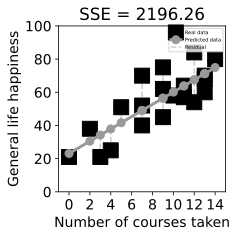

In [3]:
numcourses = [13,4,12,3,14,13,12,9,11,7,13,11,9,2,5,7,10,0,9,7]
happiness  = [70,25,54,21,80,68,84,62,57,40,60,64,45,38,51,52,58,21,75,70]


# Build a statistical model with an intercept

# design matrix as a column vector
X = np.hstack((np.ones((20,1)),np.array(numcourses,ndmin=2).T))
print(X.shape)

# fit the model using the left-inverse
X_leftinv = np.linalg.inv(X.T@X) @ X.T

# solve for the coefficients
beta = X_leftinv @ happiness
beta

# let's plot it!

# predicted data
pred_happiness = X@beta


plt.figure(figsize=(3,3))

# plot the data and predicted values
plt.plot(numcourses,happiness,'ks',markersize=15)
plt.plot(numcourses,pred_happiness,'o-',color=[.6,.6,.6],linewidth=3,markersize=8)

# plot the residuals (errors)
for n,y,yHat in zip(numcourses,happiness,pred_happiness):
  plt.plot([n,n],[y,yHat],'--',color=[.8,.8,.8],zorder=-10)

plt.xlabel('Number of courses taken')
plt.ylabel('General life happiness')
plt.xlim([-1,15])
plt.ylim([0,100])
plt.xticks(range(0,15,2))
plt.legend(['Real data','Predicted data','Residual'],fontsize=5)
plt.title(f'SSE = {np.sum((pred_happiness-happiness)**2):.2f}')
plt.show()
     

Dot product: -0.0
Correlation: 0.0
 


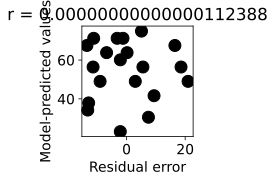

dim(  N(X)    ) = 18
dim( [N(X)|r] ) = 18


In [4]:
#Exer 1 and 2

# compute residual
res = happiness-pred_happiness


# should be zero + some error
print('Dot product: ' + str(np.round(np.dot(pred_happiness,res),2)))
print('Correlation: ' + str(np.round(np.corrcoef(pred_happiness,res)[0,1],2)))
print(' ')


# show in a plot
plt.figure(figsize=(2,2))
plt.plot(res,pred_happiness,'ko',markersize=12)
plt.xlabel('Residual error')
plt.ylabel('Model-predicted values')
plt.title(f'r = {np.corrcoef(pred_happiness,res)[0,1]:.20f}')
plt.show()


# the residual is orthogonal to the entire column space of the design matrix.

# I demonstrated this by showing that the residuals vector is in the left-null space of the design matrix.
# I did that by using scipy.linalg.null_space to find the left-null space, augmenting that null-space basis
# matrix by the residuals vector, and showing that the null space and augmented null space have the same rank.


# compute the null space (via scipy.linalg)
nullspace = scipy.linalg.null_space(X.T)


# augment the residuals
nullspaceAugment = np.hstack((nullspace,res.reshape(-1,1)) )


# print their ranks
print(f'dim(  N(X)    ) = {np.linalg.matrix_rank(nullspace)}')
print(f'dim( [N(X)|r] ) = {np.linalg.matrix_rank(nullspaceAugment)}')
     

In [5]:
M=20
N=3

X=np.random.randn(M,N)*3
y=np.random.randn(M,1)*5

#method 1: Left-Inverse
X_inv1=np.linalg.pinv(X)
X_inv2=np.linalg.pinv(X.T@X)@X.T

if(np.max(abs(X_inv1-X_inv2)))<0.00001:
    print(f'The two inverse methods return same matrix inverse')
else:
    print(f'ERRRROOOOORRR')

B_1 = X_inv1@y

#method 2: QR

Q,R=np.linalg.qr(X,"reduced")

print(f'Q: {Q.shape}, R: {R.shape}')

B_2 = np.linalg.pinv(R)@Q.T@y


#Method 3: RREF
Xy = np.hstack((R,Q.T@y))


symMat = sym.Matrix(Xy)
RREF = symMat.rref()[0]

RREF=np.array(RREF)
B_3=np.array([RREF[:,-1]]).astype(float)

print(f'Betas from Left-Inv:\n {np.round(B_1,3).T}')
print(f'Betas from QRE:\n {np.round(B_2,3).T}')
print(f'Betas from RREF:\n {np.round(B_3.T,3).T}\n')

print(f'R:\n{np.round(R,3)}')
print(f'R|QTy\n{np.round(Xy,3)}')
print(f'RREF(R|QTy)\n{np.round(RREF.astype(float),3)}')

The two inverse methods return same matrix inverse
Q: (20, 3), R: (3, 3)
Betas from Left-Inv:
 [[-0.305 -0.095 -0.207]]
Betas from QRE:
 [[-0.305 -0.095 -0.207]]
Betas from RREF:
 [[-0.305 -0.095 -0.207]]

R:
[[10.124  5.34  -3.816]
 [ 0.    13.878 -2.674]
 [ 0.     0.    -9.94 ]]
R|QTy
[[10.124  5.34  -3.816 -2.807]
 [ 0.    13.878 -2.674 -0.771]
 [ 0.     0.    -9.94   2.06 ]]
RREF(R|QTy)
[[ 1.     0.     0.    -0.305]
 [ 0.     1.     0.    -0.095]
 [ 0.     0.     1.    -0.207]]


In [6]:
#Exer 5
n=50
X=np.random.randn(n,n)
Y=np.eye(n)
Xinv_1=np.zeros_like(X)
for i in range(X.shape[0]):
    Xinv_1[:,i]=(np.linalg.pinv(X)@Y[:,i])
    
Xinv_2 = np.linalg.inv(X.T@X) @ X.T @ Y

Xinv_3 = np.linalg.inv(X)

print(np.round(np.sum(abs(Xinv_1@X-np.eye(n))),15))
print(np.round(np.sum(abs(Xinv_2@X-np.eye(n))),15))
print(np.round(np.sum(abs(Xinv_3@X-np.eye(n))),15))

1.5763e-11
8.150587e-09
1.7145e-11


In [7]:
A=np.linspace(0,3,12)

print(A)
print(A.shape)
print("\n")
A_r=A.reshape(3,-1)
print(A_r)
print(A_r.shape)

[0.         0.27272727 0.54545455 0.81818182 1.09090909 1.36363636
 1.63636364 1.90909091 2.18181818 2.45454545 2.72727273 3.        ]
(12,)


[[0.         0.27272727 0.54545455 0.81818182]
 [1.09090909 1.36363636 1.63636364 1.90909091]
 [2.18181818 2.45454545 2.72727273 3.        ]]
(3, 4)
